In [24]:
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime, os, glob, json, string, inspect, emcee
from scipy.stats import median_abs_deviation, poisson
from matplotlib.patches import Circle, Ellipse
from astropy.wcs import WCS
from astropy.nddata import Cutout2D
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from astropy.io import ascii, fits
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time
from PyDynamic import interp1d_unc
from astropy.table import Table
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)
import pickle as p

## Solve for Lr-Lx points by interpolating the radio onto the X-ray times

In [45]:
def weighted_average(y,dy):
    '''
    Calculate the (variance)-weighted average
    y is a 1-D array 
    dy can be a 1-D array or a (2,len(y)) array for asymetric errors
    '''
    
    # Convert to numpy arrays
    y  = np.array(y)
    dy = np.array(dy)
    
    # If dy is 2-D adopt the largest error as the conservative symetric approximation 
    if len(dy.shape) == 2:
        dy = np.amax(abs(dy), axis=0)
    
    # Calculate the averages
    avg = np.average(y, weights = dy ** (-2))
    err = (np.sum(dy ** (-2))) ** (-0.5)
    
    return avg, err

# Distance in kpc from PRE burst
d     = 4.9 * 3.08567758128e+21
d_err = 0.3 * 3.08567758128e+21

# Swift-XRT spectral dictionary -- keys describe each entry 
with open('../../analysis/swift-xrt/results/fit_dict_full_Emin1.0.json') as jfile:
    xrt_spectra = json.load(jfile)
    
for key in xrt_spectra.keys():
    xrt_spectra[key] = np.array(xrt_spectra[key])
xrt_spectra['tot_flux'] = xrt_spectra['flux'] + xrt_spectra['bb_flux']
xrt_spectra['tot_flux_neg'] = np.sqrt(xrt_spectra['flux_neg']**2 + xrt_spectra['bb_flux_neg']**2)
xrt_spectra['tot_flux_pos'] = np.sqrt(xrt_spectra['flux_pos']**2 + xrt_spectra['bb_flux_pos']**2)

# Load in the lowcount xrt spectra
with open('../../analysis/swift-xrt/results/fit_dict_lowcount_Emin1.0.json') as jfile:
    xrt_lowcount = json.load(jfile)
xrt_lowcount_times = Time(xrt_lowcount['times'], format='isot').mjd
xrt_spectra['tot_flux'] = np.append(xrt_spectra['tot_flux'], xrt_lowcount['flux'])
xrt_spectra['tot_flux_neg'] = np.append(xrt_spectra['tot_flux_neg'], xrt_lowcount['flux_neg'])
xrt_spectra['tot_flux_pos'] = np.append(xrt_spectra['tot_flux_pos'], xrt_lowcount['flux_pos'])
xrt_times = Time(np.append(xrt_spectra['times'],xrt_lowcount['times']), format='isot').mjd

# MeerKAT Flux Densities 
MeerKAT_isot, _ = np.load('../../analysis/meerkat/results/imfit_times.npy')
MeerKAT_times = Time(MeerKAT_isot, format='isot').mjd
MeerKAT_flux = np.load('../../analysis/meerkat/results/imfit_flux_results.npy')

# Match data points using a simple linear interpolation
_, radio_interp, radio_err_interp = interp1d_unc(xrt_times, MeerKAT_times, MeerKAT_flux[0], MeerKAT_flux[1])


# Define functions to solve for the lum
def x_lum(x,x_d,x_u, d, d_err):
    lx   = 4 * np.pi * x * d ** 2
    lx_d = 4 * np.pi * np.sqrt((d ** 2 * x_d) ** 2 + (2 * d * x * d_err) ** 2) 
    lx_u = 4 * np.pi * np.sqrt((d ** 2 * x_u) ** 2 + (2 * d * x * d_err) ** 2) 

    return lx, lx_d, lx_u

def r_lum(r,r_d,r_u, d, d_err):  
    lr   = 1.0e-6 * 1e-23 * 5e9 * 4 * np.pi * r * d ** 2
    lr_d = 1.0e-6 * 1e-23 * 5e9 * 4 * np.pi * np.sqrt((d ** 2 * r_d) ** 2 + (2 * d * r * d_err) ** 2) 
    lr_u = 1.0e-6 * 1e-23 * 5e9 * 4 * np.pi * np.sqrt((d ** 2 * r_u) ** 2 + (2 * d * r * d_err) ** 2) 

    return lr, lr_d, lr_u

# 2021 Outburst data
lx, lx_d, lx_u = x_lum(xrt_spectra['tot_flux'],xrt_spectra['tot_flux_neg'],xrt_spectra['tot_flux_pos'], d, d_err)
lr, lr_d, lr_u = r_lum(radio_interp,radio_err_interp,radio_err_interp, d, d_err)

# Simple power-law calculation
power_law, cov = np.polyfit(np.log(lx), np.log(lr), deg = 1, cov=True)
print('Full Lr-Lx Power-law index {} +/- {}'.format(power_law[0], np.sqrt(cov[0][0])))

# The 2023 epoch 
lx_2023, _, _ = x_lum(np.array([1.2771250151970527e-13, 3.0203551208003815e-13]), 0.0, 0.0, d, 0.0)
lr_2023, lr_2023_d, lr_2023_u = r_lum(MeerKAT_flux[0][-2:], MeerKAT_flux[1][-2:], MeerKAT_flux[1][-2:], d, d_err)

# Make an alternative plotting form where we subtract 90 uJy and only include data that are ~3-sigma above 0
# All others will be upper limits 
lr_corr = lr - 93.0 * 1.0e-6 * 1e-23 * 5e9 * 4 * np.pi * d ** 2
lr_corr_u = lr_u.copy()
lr_corr_d = lr_d.copy()

# Find points where the subtracted signal is < 3 and set as upper limits
#snr = (MeerKAT_flux[0][:-1] - 100) / MeerKAT_flux[1][:-1]
snr  =  (radio_interp - 93.0) / radio_err_interp

threshold=3.0
lr_corr[snr < threshold] = 3 * lr_u[snr < threshold]
lr_corr_u[snr < threshold] = 0.0
lr_corr_d[snr < threshold] = 0.25 * lr_corr[snr < threshold]

lr_corr_ulim = np.zeros(len(lr_corr))
lr_corr_ulim[snr < threshold] = 1
lr_corr_ulim = lr_corr_ulim.astype(bool)

power_law, cov = np.polyfit(np.log(lx[snr > threshold]), np.log(lr[snr > threshold]), deg = 1, cov=True)
print('Subset Lr-Lx Power-law index {} +/- {}'.format(power_law[0], np.sqrt(cov[0][0])))

Full Lr-Lx Power-law index 0.08928541622088691 +/- 0.019582682728965344
Subset Lr-Lx Power-law index 0.19364787570531886 +/- 0.08221741068371148


## Archival Lr-Lx using van den Eijen 2022 (2207.03962)

In [40]:
#########################
# Arash Lr Lx data base #
#########################

with open('../../analysis/catalogs_from_literature/lrlx_data.p', 'rb') as pfile:
    archival_data = p.load(pfile)
        
# Initialize array filled with hard-state sources
source_dict = {'BH': {'Lr':[], 'Lr_neg':[], 'Lr_pos':[], 'Lx':[], 'Lx_neg':[], 'Lx_pos':[], 'uplim':[]},
               'NS': {'Lr':[], 'Lr_neg':[], 'Lr_pos':[], 'Lx':[], 'Lx_neg':[], 'Lx_pos':[], 'uplim':[]},
               'AMXP': {'Lr':[], 'Lr_neg':[], 'Lr_pos':[], 'Lx':[], 'Lx_neg':[], 'Lx_pos':[], 'uplim':[]}}
    
# Make arrays of BHs and Neutrons Stars in the hard state from the Arash Database
for source in archival_data:
    source_Class = source['Class']
        
    # Iterate throught the source classes of interest and append them to relevant Dictionary Key 
    for Class in ['BH', 'NS', 'AMXP']:
        if source_Class in Class:
            
            # Append the Fluxes
            source_dict[Class]['Lr'] += source['Lr'].tolist()
            source_dict[Class]['Lx'] += source['Lx'].tolist()
                    
            # Append the errors
            for band in ['Lr', 'Lx']:
                if source['{}_er'.format(band)].size == 0: # If no error append zeros
                    source_dict[Class]['{}_neg'.format(band)] +=  len(source[band]) * [0.0]
                    source_dict[Class]['{}_pos'.format(band)] +=  len(source[band]) * [0.0]
                elif source['{}_er'.format(band)].ndim == 2:
                    source_dict[Class]['{}_neg'.format(band)] +=  source['{}_er'.format(band)][0].tolist()
                    source_dict[Class]['{}_pos'.format(band)] +=  source['{}_er'.format(band)][1].tolist()
                else: 
                    source_dict[Class]['{}_neg'.format(band)] +=  source['{}_er'.format(band)].tolist()
                    source_dict[Class]['{}_pos'.format(band)] +=  source['{}_er'.format(band)].tolist()
                   
            # Record if they are upper limits (only applies to radio)
            if source['uplim'] is not None:
                source_dict[Class]['uplim'] += len(source['Lr']) * [True]
                
            else: 
                source_dict[Class]['uplim'] += len(source['Lr']) * [False]
                
#################################
# vdE 2022 non-datebase sources #
#################################

# Taken from: https://github.com/jvandeneijnden/MeerKATCampaignOfCenXm4/blob/main/Reproduction_Notebook_Python3.ipynb
Fr_vdE21 = np.asarray([63.7, 30.0, 20.0, 21.0, 30., 2.6, 4.0, 431., 87., 14., 14., 21., 22., 24.]) * u.microJansky
dFr_vdE21 = np.asarray([3.7, 15., 10., 10.5, 15., 1.3, 2.0, 7.0, 11.0, 7., 7., 10.5, 11., 12.])* u.microJansky

Fx_vdE21 = np.asarray([2e-9, 5.9e-9, 3.0e-10, 3.8e-10, 6.3e-11, 3.7e-12, 2.6e-12, 2.1e-10, 8.5e-11, 3e-12, 3.9e-11, 3e-12, 8.8e-13, 2.2e-12])* u.erg/u.second/(u.cm**2)
dFx_vdE21 = np.asarray([0.2e-9, 0.2e-9, 0.1e-10, 0.1e-10, 0.5e-11, 0.4e-12, 0.3e-12, 0.1e-10, 0.7e-11, 1e-12, 0.3e-11, 1e-12, 4.4e-13, 1.1e-12])* u.erg/u.second/(u.cm**2)

D_vdE21 = np.asarray([5., 8.5, 4., 4.3, 7.3, 9.5, 9.2, 8.0,8.0,8.0,8.0,8.0,8.0,8.0]) * u.kpc

det_vdE21 = np.asarray([True, False, False, False, False, False, False, True, True, False, False, False, False, False])

Lx_vdE21 = (4.*np.pi*Fx_vdE21*(D_vdE21**2)).to(u.erg/u.second).value
dLx_vdE21 = (4.*np.pi*dFx_vdE21*(D_vdE21**2)).to(u.erg/u.second).value

Lr_vdE21 = (4.*np.pi*Fr_vdE21*(5*u.GHz)*(D_vdE21**2)).to(u.erg/u.second).value
dLr_vdE21 = (4.*np.pi*dFr_vdE21*(5*u.GHz)*(D_vdE21**2)).to(u.erg/u.second).value

Lx_C4 = [6.0e31, 1.3e33, 5.5e32, 3.5e32]
dLx_C4 = [1.7e31, 0.3e33, 0.4e32, 0.9e32]
Lr_UL_C4 = [1.1e26, 5.9e26, 4.7e26, 4.1e26]
dLr_C4  = (0.25 * np.array(Lr_UL_C4)).tolist()

# Append to the array
source_dict['NS']['Lr'] += Lr_vdE21.tolist() + Lr_UL_C4
source_dict['NS']['Lx'] += Lx_vdE21.tolist() + Lx_C4

source_dict['NS']['Lr_neg'] += dLr_vdE21.tolist() + dLr_C4
source_dict['NS']['Lr_pos'] += dLr_vdE21.tolist() + [0.0,0.0,0.0,0.0]

source_dict['NS']['Lx_neg'] += dLx_vdE21.tolist() + dLx_C4
source_dict['NS']['Lx_pos'] += dLx_vdE21.tolist() + dLx_C4

source_dict['NS']['uplim'] += det_vdE21.tolist() + [True, True, True, True]

###############################
# Sources from Maveric Survey #
###############################

Fr_MAV = np.asarray([12.9, 13.7, 6.6, 213., 12.9, 26.9, 16.1]) * u.microJansky
dFr_MAV = np.asarray([6.45, 6.85, 3.3, 5.1, 6.45, 4.3, 8.05]) * u.microJansky

Fx_MAV = np.asarray([1.6e-10, 8.6e-10, 1.9e-11, 5.3e-12, 8.0e-12, 0.9e-12, 3.5e-13]) * u.erg/u.second/(u.cm**2)
dFx_MAV = np.asarray([0.1e-10, 2.0e-10, 0.1e-11, 4.0e-12, 4.8e-12, 0.6e-12, 1.4e-13]) * u.erg/u.second/(u.cm**2)

D_MAV = np.asarray([8.0, 13.4, 10.0, 7.0, 7.0, 7.0, 10.3]) * u.kpc

det_MAV = np.asarray([False, False, False, True, False, True, False])

Lx_MAV = (4.*np.pi*Fx_MAV*(D_MAV**2)).to(u.erg/u.second).value
dLx_MAV = (4.*np.pi*dFx_MAV*(D_MAV**2)).to(u.erg/u.second).value

Lr_MAV = (4.*np.pi*Fr_MAV*(5*u.GHz)*(D_MAV**2)).to(u.erg/u.second).value
dLr_MAV = (4.*np.pi*dFr_MAV*(5*u.GHz)*(D_MAV**2)).to(u.erg/u.second).value

# Append to the array
source_dict['NS']['Lr'] += Lr_MAV.tolist()
source_dict['NS']['Lx'] += Lx_MAV.tolist()

source_dict['NS']['Lr_neg'] += dLr_MAV.tolist()
source_dict['NS']['Lr_pos'] += dLr_MAV.tolist()

source_dict['NS']['Lx_neg'] += dLx_MAV.tolist()
source_dict['NS']['Lx_pos'] += dLx_MAV.tolist()

source_dict['NS']['uplim'] += det_MAV.tolist()

#######################
# Aql X-1 hard state  #
#######################

# See https://ui.adsabs.harvard.edu/abs/2020MNRAS.492.2858G/abstract

Lx_Aqx1, dLx_AqX1 = np.genfromtxt('../../analysis/catalogs_from_literature/aqlx1_lx.txt', unpack=True)
Lx_Aqx1 = Lx_Aqx1 * 1e36
dLx_Aqx1 = dLx_AqX1 * 1e36

Lr_Aqx1, dLr_Aqx1 = np.genfromtxt('../../analysis/catalogs_from_literature/aqlx1_lr.txt', unpack=True)
Lr_UL_Aqx1 = []

for i in range(len(Lr_Aqx1)):
    if dLr_Aqx1[i] < 0:
        Lr_UL_Aqx1.append(True)
        dLr_Aqx1[i] = Lr_Aqx1[i]*0.25*1.0e28
    else:
        Lr_UL_Aqx1.append(False)
        dLr_Aqx1[i] = dLr_Aqx1[i]*1.0e28
Lr_Aqx1 = Lr_Aqx1 * 1e28
Lr_UL_Aqx1 = np.asarray(Lr_UL_Aqx1)

HR_Aqx1 = np.genfromtxt('../../analysis/catalogs_from_literature/aqlx1_HR.txt', unpack=True, usecols=[0])

# Shielding the points with low HR (following Gusinskaia + 2020), by setting their Lx to 1 erg/s 
# (so they are not visible in the figure)
for i in range(len(HR_Aqx1)):
    if HR_Aqx1[i] < 0.75:
        Lx_Aqx1[i] = 1.0
        dLx_Aqx1[i] = 0.0
        
source_dict['NS']['Lr'] += Lr_Aqx1.tolist()
source_dict['NS']['Lx'] += Lx_Aqx1.tolist()

source_dict['NS']['Lr_neg'] += dLr_Aqx1.tolist()
source_dict['NS']['Lr_pos'] += dLr_Aqx1.tolist()

source_dict['NS']['Lx_neg'] += dLx_Aqx1.tolist()
source_dict['NS']['Lx_pos'] += dLx_Aqx1.tolist()

source_dict['NS']['uplim'] += Lr_UL_Aqx1.tolist()

## Plot the Lr-Lx Light curves

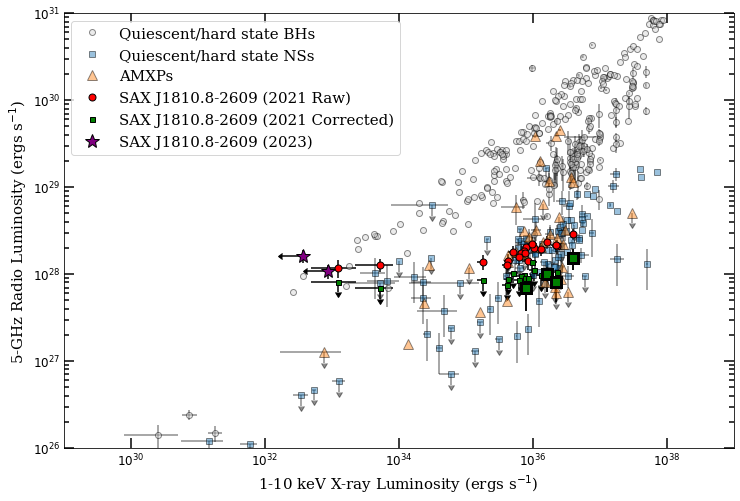

In [41]:
############################
# Plot the Lr--Lx relation #
############################

# Change the lower error bars on the upperlims for cleare plotting
for Class in ['NS', 'BH', 'AMXP']:
    index = source_dict[Class]['uplim']
    source_dict[Class]['Lr_neg'] = np.array(source_dict[Class]['Lr_neg'])
    source_dict[Class]['Lr'] = np.array(source_dict[Class]['Lr'])
    source_dict[Class]['Lr_neg'][index] = (0.25 * source_dict[Class]['Lr'][index])

font_size=15
fig, ax = plt.subplots(figsize=(12,8))

# Format basic axis + add axis labels
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim(1e29, 1e39)
ax.set_ylim(1e26, 1e31)
ax.set_ylabel(r'5-GHz Radio Luminosity (ergs s$^{-1}$)', fontsize= font_size, fontfamily='serif')
ax.set_xlabel(r'1-10 keV X-ray Luminosity (ergs s$^{-1}$)', fontsize= font_size, fontfamily='serif')
ax.tick_params(axis='both', which='minor', direction='in',length=5,width=1.5,top=True,right=True)
ax.tick_params(axis='both', which='major', direction='in',length=10,width=1.5,top=True,right=True, labelsize=12)
ax.minorticks_on()

# Plot the archival data -- Black holes
Class = 'BH'
ax.errorbar(source_dict[Class]['Lx'], source_dict[Class]['Lr'], 
            xerr = [source_dict[Class]['Lx_neg'], source_dict[Class]['Lx_pos']],
            yerr = [source_dict[Class]['Lr_neg'], source_dict[Class]['Lr_pos']],
            uplims=source_dict[Class]['uplim'],
            fmt='o', color='lightgrey', mec='k', ecolor='k', label='Quiescent/hard state BHs', alpha=0.45)

Class = 'NS'
ax.errorbar(source_dict[Class]['Lx'], source_dict[Class]['Lr'], 
            xerr = [source_dict[Class]['Lx_neg'], source_dict[Class]['Lx_pos']],
            yerr = [source_dict[Class]['Lr_neg'], source_dict[Class]['Lr_pos']],
            uplims=source_dict[Class]['uplim'],
            fmt='s', color='C0', mec='k', ecolor='k', label='Quiescent/hard state NSs', alpha=0.45)

Class = 'AMXP'
ax.errorbar(source_dict[Class]['Lx'], source_dict[Class]['Lr'], 
            xerr = [source_dict[Class]['Lx_neg'], source_dict[Class]['Lx_pos']],
            yerr = [source_dict[Class]['Lr_neg'], source_dict[Class]['Lr_pos']],
            uplims=source_dict[Class]['uplim'],
            fmt='^', ms = 10, color='C1', mec='k', ecolor='k', label='AMXPs', alpha=0.45)

# Plot the SAX J1810 data
ax.errorbar(lx, lr, 
            yerr=[lr_d, lr_u], 
            xerr=[lx_d, lx_u], 
            fmt='o', ms='7', color='red', mec='k', ecolor='k', label = 'SAX J1810.8-2609 (2021 Raw)')

ax.errorbar(lx, lr_corr, 
            yerr=[lr_corr_d, lr_corr_u], 
            xerr=[lx_d, lx_u], uplims = lr_corr_ulim,
            fmt='s', ms='5', color='green', mec='k', ecolor='k', label = 'SAX J1810.8-2609 (2021 Corrected)')

ax.errorbar(lx[np.invert(lr_corr_ulim)], lr_corr[np.invert(lr_corr_ulim)],
            yerr=[lr_corr_d[np.invert(lr_corr_ulim)], lr_corr_u[np.invert(lr_corr_ulim)]], 
            xerr=[lx_d[np.invert(lr_corr_ulim)], lx_u[np.invert(lr_corr_ulim)]],
            fmt='s', ms='10', color='green', mec='k', mew=3, ecolor='k')

ax.errorbar(lx_2023, lr_2023, 
            yerr=[lr_2023_d, lr_2023_u], 
            xerr=[lx_2023 * 0.5 , [0.0, 0.0]], 
            xuplims=True, fmt='*', ms='15', color='purple', mec='k', ecolor='k', label = 'SAX J1810.8-2609 (2023)')

handles, labels = ax.get_legend_handles_labels()
handles = [h[0] for h in handles]
ax.legend(handles,labels, prop={'family':'serif', 'size':15})
plt.show()